# Imports

In [22]:
import torch
import random
import torch.nn as nn
import cv2
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
import copy

In [23]:
np.random.seed(123)  # for replication
os.makedirs('./models', exist_ok=True)
# Directory containing the test dataset
test_dir = './dataset/GTSRB-leveled/test'
# Directory containing the train dataset
train_dir = './dataset/GTSRB-leveled/train'

# Helper functions

In [24]:
def plot_classes_preds(images, labels, preds, probs):
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx + 1, xticks=[], yticks=[])
        norm_img = cv2.normalize(images[idx].cpu().numpy(), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        rgb_img = np.transpose(norm_img, (1, 2, 0)).astype(np.uint8)
        plt.imshow(rgb_img)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            preds[idx],
            probs[idx] * 100.0,
            labels[idx]),
            color=("green" if preds[idx] == labels[idx].item() else "red"))
    return fig

### Loading the train dataset

Train size: 101050
Class names: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


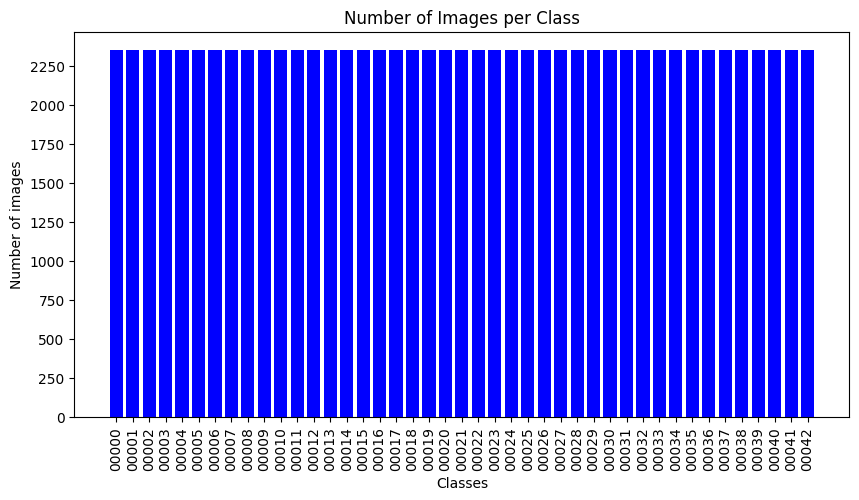

In [25]:
# Define your transformations
custom_cnn_transform = transforms.Compose([
    transforms.Resize((30, 30)),  # Resize to 30x30
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

# Load the dataset using the torchvision.datasets.ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=custom_cnn_transform)
train_size = len(train_dataset)
class_names = train_dataset.classes

print('Train size:', train_size)
print('Class names:', class_names)

# Use numpy to count occurrences of each class index in targets
counts = np.bincount(train_dataset.targets)

# Create histogram
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class')
plt.xticks(rotation=90)  # Rotate class names for better visibility if needed
plt.yticks(np.arange(0, max(counts) + 10, 250))  # Adjust the range and step size as needed
plt.show()

### Loading the test dataset

Test size: 12630
Class names: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


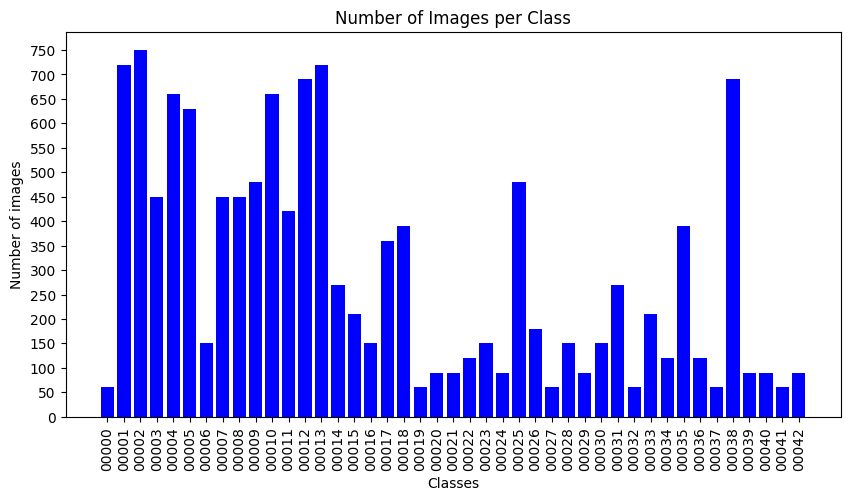

In [26]:
# Load the dataset using the torchvision.datasets.ImageFolder
test_dataset = datasets.ImageFolder(test_dir, transform=custom_cnn_transform)
test_size = len(test_dataset)
class_names = test_dataset.classes

print('Test size:', test_size)
print('Class names:', class_names)

# Use numpy to count occurrences of each class index in targets
counts = np.bincount(test_dataset.targets)

# Create histogram
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class')
plt.xticks(rotation=90)  # Rotate class names for better visibility if needed
plt.yticks(np.arange(0, max(counts) + 10, 50))  # Adjust the range and step size as needed
plt.show()


# Defining the CNN

In [27]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Expected input as 30x30
        # First block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Second block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 512)
        self.dropout3 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 256)
        self.dropout4 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(256, 43)

    def forward(self, x):
        # First block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Flatten the output for the dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))
        x = self.dropout4(x)
        x = self.fc3(x)
        return x

# Defining the training phase

In [28]:
def test_model(trained_model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        trained_model.eval()
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = trained_model(images)
            softmax_outputs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(softmax_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = float(correct / total)
    print('{} Model accuracy: {:.4f}'.format('Test phase - ', test_accuracy))
    writer.add_scalar('Training/Test Accuracy', test_accuracy)
    return test_accuracy


def train_model(device, model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25,
                model_name='trained_model'):
    since = time.time()
    time_train = 0
    time_val = 0

    # Save the initial model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0

            # Choose the appropriate data loader
            if phase == 'train':
                model.train()  # Set model to training mode
                data_total_steps = len(train_loader)
                data_loader = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                data_total_steps = len(val_loader)
                data_loader = val_loader

            for i, (images, labels) in enumerate(data_loader):
                # time_t = epoch * len(data_loader) * i + i

                images = images.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    softmax_outputs = F.softmax(outputs, dim=1)
                    probs, preds = torch.max(softmax_outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)

                #prints the stats every 20 steps (20 batches performed)
                if (i + 1) % int(data_total_steps / 8) == 0:
                    print(
                        f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{data_total_steps}], Loss: {loss.item():.4f}')

                    # Log image predictions
                    selected_indices = random.sample(range(len(images)), 4)  # Select 4 random indices
                    selected_images = images[selected_indices]
                    selected_labels = labels[selected_indices]
                    selected_preds = preds[selected_indices]
                    selected_probs = probs[selected_indices]
                    if phase == 'train':
                        writer.add_figure('Training/Training Predictions',
                                          plot_classes_preds(selected_images, selected_labels, selected_preds,
                                                             selected_probs),
                                          global_step=time_train)
                    else:
                        writer.add_figure('Training/Validation Predictions',
                                          plot_classes_preds(selected_images, selected_labels, selected_preds,
                                                             selected_probs),
                                          global_step=time_val)

                # Log scalars
                if phase == 'train':
                    writer.add_scalar('Training/Training Loss',
                                      loss.item(),
                                      time_train)
                    writer.add_scalar('Policy/Learning Rate',
                                      np.array(scheduler.get_last_lr()),
                                      time_train)
                    time_train += 1
                else:
                    writer.add_scalar('Training/Validation Loss',
                                      loss.item(),
                                      time_val)
                    time_val += 1

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            if phase == 'train':
                print('{} Epoch {} Loss: {:.4f} Acc: {:.4f}'.format(
                    'Train phase - ', epoch + 1, epoch_loss, epoch_acc))
                writer.add_scalar('Training/Training Accuracy',
                                  epoch_acc,
                                  epoch)
                if (epoch + 1) % max(int(num_epochs / 5), 1) == 0:  # checkpoint the model
                    print("----> model checkpoint...")
                    torch.save(model, f'./models/trained_model_{model_name}_epoch_{epoch + 1}.pth')
            else:
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                print('{} Epoch {} Loss: {:.4f} Acc: {:.4f}'.format(
                    'Validation phase - ', epoch + 1, epoch_loss, epoch_acc))
                writer.add_scalar('Training/Validation Accuracy',
                                  epoch_acc,
                                  epoch)
                scheduler.step(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc:{:.4f}'.format(best_acc))
    # Return the model with the best accuracy in the validation
    model.load_state_dict(best_model_wts)
    
    return model

## Training Setup

In [29]:
# Setting device for the computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
hyperparams = {
    "num_epochs": 15,
    "batch_size": 64,
    #optimizer
    "opt": "adam",
    "learning_rate": 2e-4,
    #scheduler
    "decay_rate": 0.5,
}

### Setting up the model using ResNet50 as backbone

In [30]:
# default `log_dir` is "runs" - we'll be more specific here
model_name = 'Custom-CNN_dataset-leveled'
writer = SummaryWriter(f'runs/{model_name}')

test_abs = int(len(train_dataset) * 0.8)
train_subset, val_subset = random_split(
    train_dataset, [test_abs, len(train_dataset) - test_abs])

train_data_size = len(train_subset)

# Create DataLoader instances for training and validation
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=hyperparams["batch_size"],
    shuffle=True,
    num_workers=4)
val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=hyperparams["batch_size"],
    shuffle=True,
    num_workers=4)
test_loader = DataLoader(
    test_dataset,
    batch_size=hyperparams["batch_size"],
    shuffle=True,
    num_workers=2)

# Model initialization
model = TrafficSignNet().to(device)

# Define loss function, optimizer, etc.
criterion = nn.CrossEntropyLoss()
# Set optimizers
if hyperparams['opt'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])
elif hyperparams['opt'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])
elif hyperparams['opt'] == 'rmsprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=hyperparams["learning_rate"])
else:
    raise ValueError('Invalid optimizer provided')
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=hyperparams["decay_rate"], min_lr=1e-6,
                                           mode='min', threshold=1e-3)

### Train the model

In [31]:
# Train model
trained_model = train_model(device=device, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                            train_loader=train_loader, val_loader=val_loader, num_epochs=hyperparams["num_epochs"],
                            model_name=model_name)

ta = test_model(trained_model=trained_model, test_loader=test_loader)
writer.add_hparams({key: str(value) if isinstance(value, list) else value for key, value in hyperparams.items()},
                   metric_dict={'Training/Test Accuracy': ta})

----------
Epoch 1/15
----------
Epoch [1/15], Step [158/1264], Loss: 3.2878
Epoch [1/15], Step [316/1264], Loss: 2.9162
Epoch [1/15], Step [474/1264], Loss: 2.3877
Epoch [1/15], Step [632/1264], Loss: 1.8020
Epoch [1/15], Step [790/1264], Loss: 1.7024
Epoch [1/15], Step [948/1264], Loss: 1.3292
Epoch [1/15], Step [1106/1264], Loss: 1.1394
Epoch [1/15], Step [1264/1264], Loss: 1.9286
Train phase -  Epoch 1 Loss: 2.1519 Acc: 0.3833
Epoch [1/15], Step [39/316], Loss: 0.8208
Epoch [1/15], Step [78/316], Loss: 0.9120
Epoch [1/15], Step [117/316], Loss: 0.7875
Epoch [1/15], Step [156/316], Loss: 1.1478
Epoch [1/15], Step [195/316], Loss: 0.7718
Epoch [1/15], Step [234/316], Loss: 1.1001
Epoch [1/15], Step [273/316], Loss: 0.8091
Epoch [1/15], Step [312/316], Loss: 1.4240
Validation phase -  Epoch 1 Loss: 0.8632 Acc: 0.7773
----------
Epoch 2/15
----------
Epoch [2/15], Step [158/1264], Loss: 1.2256
Epoch [2/15], Step [316/1264], Loss: 0.6348
Epoch [2/15], Step [474/1264], Loss: 0.8579
Epoch

# Saving the trained model

In [32]:
print('Finished Training')
torch.save(trained_model, f'./models/trained_model_{model_name}_final.pth')

Finished Training
